# Guided Capstone
- Problem statement
- Data set description
- Attempt at linear regression reveals multicolinearity problem
- Exploratory data analysis with Principal Components Analysis (PCA)
- Results

## Problem Statement
A Montana ski resort wants to increase revenues to cover increased costs. This analysis will develop a simple comparitive ski lift ticket pricing model using data from ski resort peers across the United States. Model prices of this resort (and it's competition) provide suggestions and justification for pricing changes to the ski resort management.

The pricing model will include features such as terrain parameters (elevations, acreage, snowfall, etc.) and amenities (detailed inventory of ski lift including number of lifts and lift capacity). The model will target the prices of ski lift tickets for weekdays and weekends.

The simplest model will be based on a linear regression. Other, more sophisticated approaches (e.g. including new features such as geograpical proximity) will be suggested.

### Perspectives
1. Colinearity
Technical issues include strong correlations between features. This introduces a problem known as colinearity. Colinearity introduces instability into linear regression such that the coefficients swing wildly with random fluctuations in the training set. It also suggests that there may be a representation with reduced dimensionality.
2. PCA
To estimate dimensionality, we examine the singular vectors associated with the largest singular values. 
3. Regularization
Regularization may be necessary to introduce constraints to help stabilize the numerical coefficiencts in a simple linear regression.

## PCA data exploration

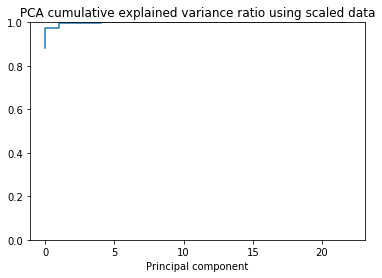

[0.881 0.975 0.997 0.999 0.999 0.999 1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]


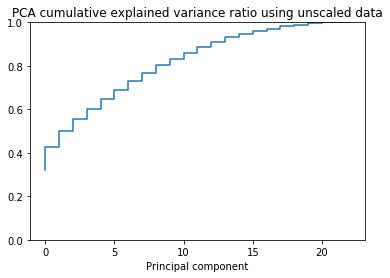

[0.321 0.428 0.501 0.555 0.602 0.648 0.691 0.732 0.769 0.805 0.833 0.861
 0.886 0.909 0.93  0.947 0.96  0.971 0.982 0.989 0.996 1.    1.   ]


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('../data/step3_output.csv')
df.drop(df.columns[[0,1]],axis=1, inplace=True)

df1 = df.drop(['Name','state'], axis=1)
target_columns = ['AdultWeekday','AdultWeekend']
features = df1.drop(target_columns, axis=1)
targets = df1[target_columns]

from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(features)
plt.ylim(0,1)
plt.plot(pca.explained_variance_ratio_.cumsum(), drawstyle='steps')
plt.title('PCA cumulative explained variance ratio using scaled data')
plt.xlabel('Principal component')
plt.show()
print(np.round(pca.explained_variance_ratio_.cumsum(), decimals = 3))

# Scale and center the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)
pca = PCA()
pca.fit_transform(scaled_data)
plt.ylim(0,1)
plt.plot(pca.explained_variance_ratio_.cumsum(), drawstyle='steps')
plt.title('PCA cumulative explained variance ratio using unscaled data')
plt.xlabel('Principal component')
plt.show()
print(np.round(pca.explained_variance_ratio_.cumsum(), decimals = 3))

In these plots, we can see the changes caused by standardized scaling. When the PCA is computed using raw data, the variance is explained usign just a handful of components. When the PCA is performed using features with standardized scaling, the explained variance is distributed among many components.  

Let's look at the first two principal components. Here's a scatter plot showing the first two principal components plotted against each other:

Explained variance ratio [0.88098051 0.09417357]


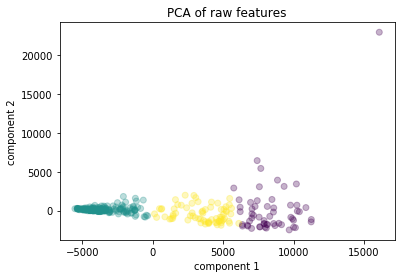

Explained variance ratio [0.32120741 0.10721983]


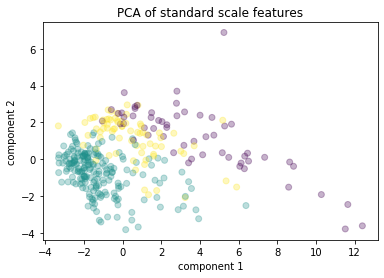

In [2]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
pca2 = PCA(2)
projected = pca2.fit_transform(features)
print('Explained variance ratio', pca2.explained_variance_ratio_)
plt.scatter(projected[:, 0], projected[:, 1], alpha = 0.3, c=features.kmeans)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('PCA of raw features')
plt.show()
projected = pca2.fit_transform(scaled_features)
print('Explained variance ratio', pca2.explained_variance_ratio_)
plt.scatter(projected[:, 0], projected[:, 1], alpha = 0.3, c=features.kmeans)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('PCA of standard scale features')
plt.show()

From this plot, we can roughly visualize that there are two or three clusters. This perspective is consistent with the elbow plot for the kmeans cluster analysis.

We can still use the principal components for dimensionality reduction. Let's proceed with regression using the following steps:

1. Scale to zero mean and unit standard deviation in each column
2. Transform features with PCA
3. Linear regression on PCA features
4. Predict target

In doing so, let's compare the effect of using PCA with and without prescaling. In the following analysis, we'll look at the effect of including different numbers of principal components, with and without scaling, and compare the results. In this section, we will train on the entire data set followed by testing on the entire data set. 

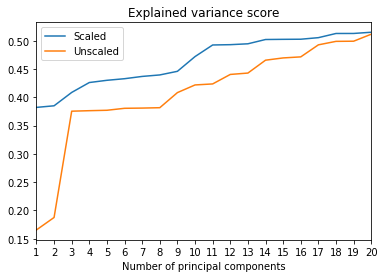

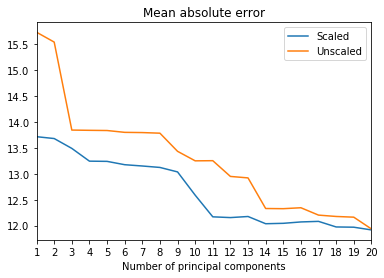

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import explained_variance_score,mean_absolute_error

number_of_components = []
evs_unscaled = []
evs_scaled = []
mae_unscaled = []
mae_scaled = []

for i in range (1,21):
    number_of_components.append(i)
    
    # Scaled PCA followed by linear regression
    steps = [
        ('scale', StandardScaler()),
        ('pca', PCA(i)),
        ('estimator', LinearRegression())
    ]

    model = Pipeline(steps)
    model.fit(features, targets)
    y_pred = model.predict(features)
    evs_scaled.append(explained_variance_score(targets, y_pred))
    mae_scaled.append(mean_absolute_error(targets ,y_pred))
    
    # Unscaled PCA followed by linear regression
    steps = [
        ('pca', PCA(i)),
        ('estimator', LinearRegression())
    ]
    model = Pipeline(steps)
    model.fit(features, targets)
    y_pred = model.predict(features)
    evs_unscaled.append(explained_variance_score(targets, y_pred))
    mae_unscaled.append(mean_absolute_error(targets ,y_pred))
         
plt.plot(number_of_components,evs_scaled, label='Scaled')
plt.plot(number_of_components,evs_unscaled, label='Unscaled')
plt.title('Explained variance score')
plt.legend()
plt.xlim((1,20))
plt.xlabel('Number of principal components')
plt.xticks(number_of_components)
plt.show()

plt.plot(number_of_components,mae_scaled, label='Scaled')
plt.plot(number_of_components,mae_unscaled, label='Unscaled')     
plt.title('Mean absolute error')
plt.legend()
plt.xlim((1,20))
plt.xlabel('Number of principal components')
plt.xticks(number_of_components)
plt.show()

## Scaling vs. unscaled
As expected, an increasing number of principal components increases the explained varaince and decreases the mean absolute error for both scaled and unscaled features. We also see that scaled features perform better than unscaled, though the two converge to nearly identical values when 20 principal components are included.

The plots of models based on unscaled features have an "elbow" feature where the performance sharply increases when the number of principal components increases from 2 to 3. If we focus strictly on model simplicity, this elbow suggests that we include 3 principal components. It also enables us to view the data in 3-dimensional plots.

Let's look again at clustering using only the first three principal component scores and see how it compares to the clusters that k-means produced in the previous step.

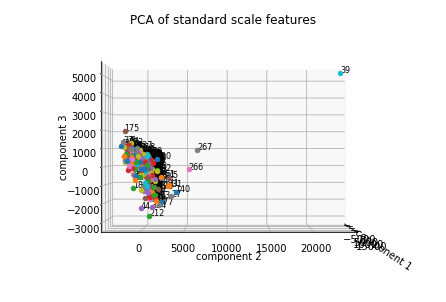

In [4]:
from mpl_toolkits.mplot3d import axes3d, Axes3D 
fig = plt.figure()
ax = Axes3D(fig)

pca3 = PCA(3)
m = pca3.fit_transform(features)

for i in range(len(m)): #plot each point + it's index as text above
    ax.scatter(m[i,0],m[i,1],m[i,2]) 
    ax.text(m[i,0],m[i,1],m[i,2],  '%s' % (str(i)), size=8, zorder=1,  
    color='k') 


ax.set_xlabel('component 1')
ax.set_ylabel('component 2')
ax.set_zlabel('component 3')
ax.set_title('PCA of standard scale features')
ax.view_init(0, 0)
plt.draw()


Clearly there are a few outliers: 39, 267 and 266 stand out. Let's look at who they are:

In [5]:
print(df.iloc[[39,266, 267]])

                   Name     state  summit_elev  vertical_drop  base_elev  \
39   Silverton Mountain  Colorado        13487           3087      10400   
266           Park City      Utah        10000           3200       6800   
267     Powder Mountain      Utah         9422           2522       6900   

     trams  fastEight  fastSixes  fastQuads  quad  ...  SkiableTerrain_ac  \
39       0        0.0          0          0     0  ...            26819.0   
266      4        0.0          6         10     4  ...             7300.0   
267      0        0.0          0          1     4  ...             8464.0   

     Snow Making_ac  daysOpenLastYear  yearsOpen  averageSnowfall  \
39       174.873239             175.0       17.0            400.0   
266      750.000000             142.0       56.0            355.0   
267      174.873239             120.0       47.0            500.0   

     AdultWeekday  AdultWeekend  projectedDaysOpen  NightSkiing_ac  kmeans  
39      79.000000      79.00000 

These resorts have a lot of skiable acreage! Maybe it's a mistake? A quick web search shows that Silverton Mountain has 1819 skiable acres. Park City does indeed have 7300 acres, and Powerder Mountain has 8464. Looks like outlier #39 is a mistake, but the others seem correct.